## Preparation

- [ ] gradient correctly established in new plate praparation?
- [ ] energy supply reasonable?
- [ ] initial kill and replication rates ok? What are reasonable limits?
- [ ] How many steps for 2k generations to expect?
- [ ] Is mutation rate development reasonable?

In [ ]:
import math
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from e1_co2_fixing.chemistry import MOLECULES, CHEMISTRY, GENOMES, get_proteome_facts
from e1_co2_fixing.util import sigm, sigm_sample, rev_sigm, rev_sigm_sample

theme_set(theme_minimal())

### Genome Sizes

- 1k nucleotides are enough for all transporters and enzymes for the largest pathway
- in a complete random genome 1k nucleotides would yield 20 proteins
- everything >> 1.5k seems excessive -> penalize in selection

In [ ]:
size = 1000
world = ms.World(chemistry=CHEMISTRY)
proteome_facts = get_proteome_facts(n=100, add_enzymes=True)
for proteome_fact in proteome_facts:
    world.generate_genome(proteome=proteome_fact, size=size)

In [ ]:
def proteome_stats(proteome: list[list], records: list[dict], size: int, record: dict):
    records.append({
        **record,
        "n": len(proteome),
        "v": "proteins/genome"
    })
    if len(proteome) > 0:
        n_doms = sum(len(d) for d in proteome)
        records.append({
            **record,
            "n": n_doms / len(proteome),
            "v": "domains/protein"
        })
        records.append({
            **record,
            "n": n_doms * genetics.dom_size / size,
            "v": "coding nts/nt"
        })

genetics = ms.Genetics()

records = []
for size in (1000, 1400, 1800):
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    for proteins in proteomes:
        proteome_stats(proteome=proteins, records=records, size=size, record={"size": size})

df = pd.DataFrame.from_records(records)
avgs = df.groupby(["v", "size"])["n"].mean().reset_index()

In [ ]:
def get_breaks(l: list[float]) -> list[float]:
    lower = math.floor(min(l))
    upper = math.ceil(max(l))
    return range(lower, upper, math.ceil((upper - lower) / 10))

(ggplot()
    + geom_histogram(aes(x="n"), data=df, bins=15)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dotted")
    + geom_text(aes(x=avgs["n"] * 1.5, y=250, label=avgs["n"].round(2)), data=avgs)
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + scale_x_continuous(breaks=get_breaks)
    + theme(figure_size=(10, 4))
    + ggtitle("Different genome sizes"))

### Mutation Rates

- for point mutations 1e-6 to 1e-4 seems ok, 1e-3 is a bit much (120% mutated after just 100s)
- recombinations only occur when a cell divides, so here `t` is in generations (not steps)
- thus 1e-6 to 1e-4 seems also ok here

In [2]:
n = 100
sizes = [1000, 1400, 1800]
ps = [1e-4, 1e-5, 1e-6]

records = []
for size in sizes:
    for p in ps:
        genomes = [ms.random_genome(s=size) for _ in range(n)]
        state = {i: 0 for i in range(n)}
        for s in range(n):
            records.extend([
                {"i": i, "t": s, "n": d, "size": size, "p": p, "l": "point-mutation"}
                for i, d in state.items()
            ])
            mutations = ms.point_mutations(seqs=genomes, p=p)
            for _, i in mutations:
                state[i] += 1

for size in sizes:
    for p in ps:
        genomes = [ms.random_genome(s=size) for _ in range(n)]
        state = {i: 0 for i in range(n)}
        for s in range(n):
            records.extend([
                {"i": i, "t": s, "n": d, "size": size, "p": p, "l": "recombination"}
                for i, d in state.items()
            ])
            mutations = ms.recombinations(seq_pairs=[(d, d) for d in genomes], p=p)
            for _0, _1, i in mutations:
                state[i] += 1

df = pd.DataFrame.from_records(records)

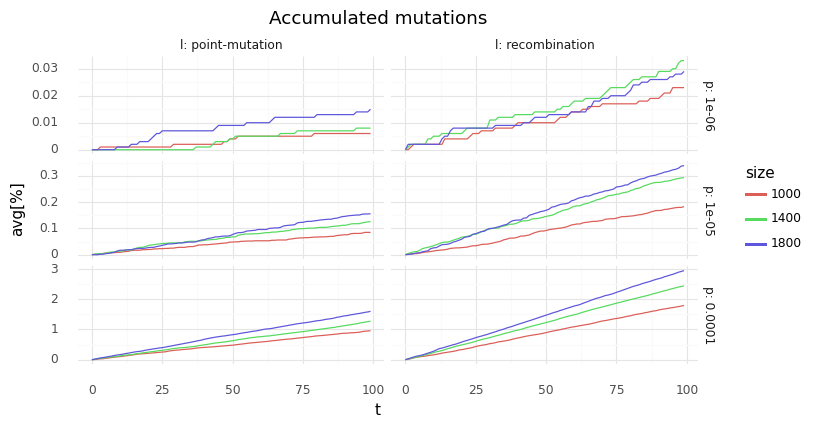

<ggplot: (8756111856586)>

In [5]:
df1 = df.groupby(["t", "size", "p", "l"])["n"].mean().reset_index()
df1["avg[%]"] = df1["n"] / df["size"] * 100
df1["size"] = [f"{int(d)}" for d in df1["size"]]

(ggplot(df1)
    + geom_line(aes(x="t", y="avg[%]", color="size"))
    + facet_grid("p ~ l", scales="free", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle("Accumulated mutations"))

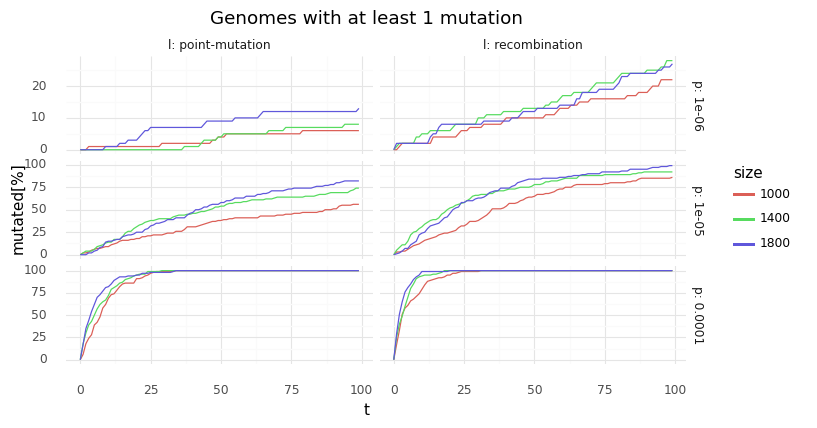

<ggplot: (8756111842362)>

In [6]:
df1 = df.groupby(["t", "size", "p", "l"])["n"].agg(lambda d: sum(d > 0) / len(d)).reset_index()
df1["mutated[%]"] = df1["n"] * 100
df1["size"] = [f"{int(d)}" for d in df1["size"]]

(ggplot(df1)
    + geom_line(aes(x="t", y="mutated[%]", color="size"))
    + facet_grid("p ~ l", scales="free", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle("Genomes with at least 1 mutation"))

### Equilibrium constants

- $K_e$ near 0 have a chance of moving in both directions
- $|log_{10}(K_e)| > 3$ is basically irreversible (e.g. highest levels are probably CO2 with 100.0: would need 0.1 product concentration to move against $|log_{10}(K_e)| = 3$)
- want to see if my chemistry even allows for that

In [7]:
world = ms.World(chemistry=CHEMISTRY)
genomes = [ms.random_genome(s=1000) for _ in range(100)]
world.add_cells(genomes=genomes)
lKe = world.kinetics.E / world.abs_temp / GAS_CONSTANT / 2.303

records = []
for lke in lKe[lKe != 0.0].flatten().tolist():
    records.append({"lKe": lke})

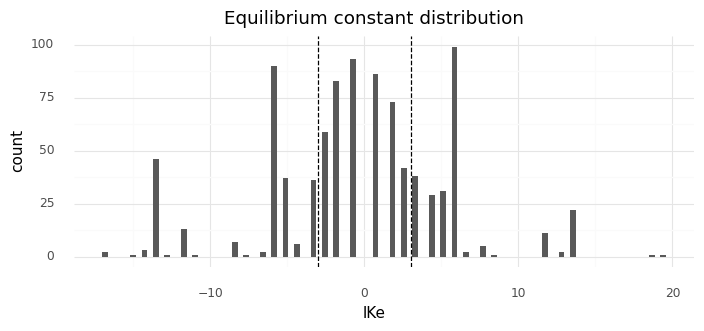

<ggplot: (8756111808422)>

In [11]:
df = pd.DataFrame.from_records(records)

(ggplot()
    + geom_histogram(aes(x="lKe"), data=df, bins=100)
    + geom_vline(aes(xintercept=[-3, 3]), linetype="dashed")
    + theme(figure_size=(8, 3))
    + ggtitle("Equilibrium constant distribution"))

In [20]:
world = ms.World(chemistry=CHEMISTRY)
genomes = [ms.random_genome(s=1000) for _ in range(100)]
world.add_cells(genomes=genomes)

kms = world.kinetics.Km[world.kinetics.Km > 0].tolist()
vmaxs = world.kinetics.Vmax[world.kinetics.Vmax > 0].tolist()

df = pd.DataFrame({
    "v": kms + vmaxs,
    "k": ["Km"] * len(kms) + ["Vmax"] * len(vmaxs)
})

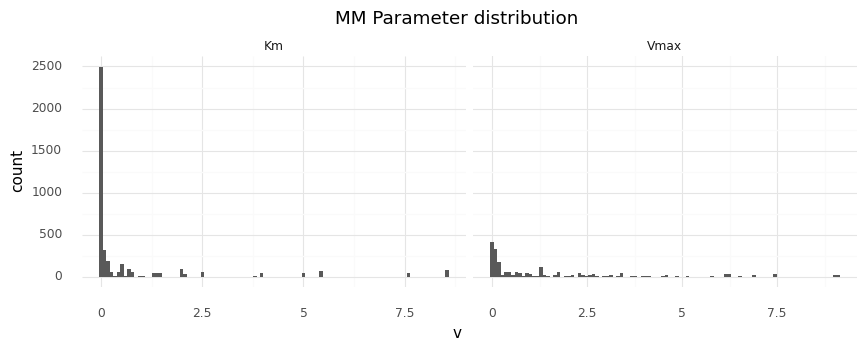

<ggplot: (8756103358098)>

In [24]:
(ggplot(df[df["v"] < 10])
    + geom_histogram(aes(x="v"), bins=100)
    + facet_grid(". ~ k", scales="free")
    + theme(figure_size=(10, 3))
    + ggtitle("MM Parameter distribution"))

### Replication and Killing

- killing depends on $X$ concentration and genome size, replication depends on $X$
- $X$-dependent functions are pretty much fine-tuning
- but I could see what ranges are useful given realist molecule concentrations
- genome sizes > 1000 should get penalized, sizes > 1500 should basically be instant death
- killed by genome size: n=7, 2000 <= k <= 2500
- killed by low X: n=3, 0.2 <= k <= 0.4
- replicated by high X: n=3, 15 <= k <= 30

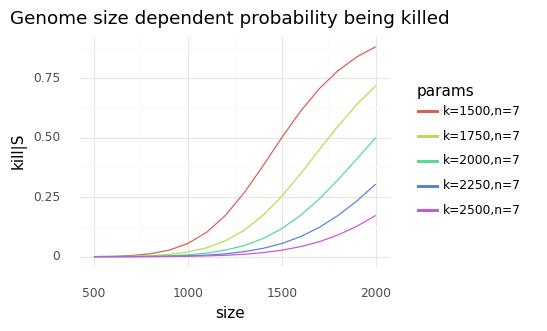

<ggplot: (8756122331263)>

In [27]:
paramsets = [
    (1500.0, 7),
    (1750.0, 7),
    (2000.0, 7),
    (2250.0, 7),
    (2500.0, 7),
]
S = torch.arange(500.0, 2001.0, 100.0)

dicts = []
for k, n in paramsets:
    name = f"k={k:.0f},n={n}"
    dicts.append({"size": S.tolist(), "kill|S": sigm(S, k=k, n=n), "params": name})
df = pd.concat([pd.DataFrame(d) for d in dicts], ignore_index=True)

(ggplot(df)
    + geom_line(aes(x="size", y="kill|S", color="params"))
    + theme(figure_size=(4, 3))
    + ggtitle("Genome size dependent probability being killed"))

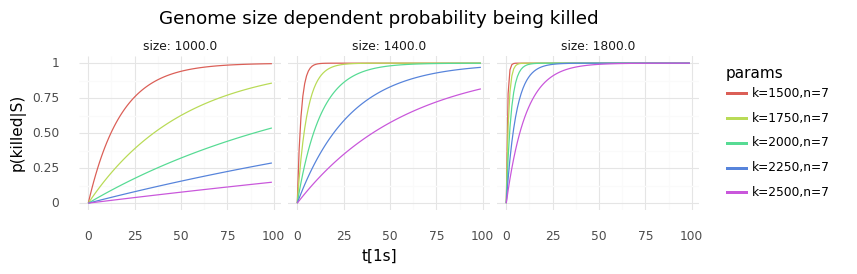

<ggplot: (8756112152402)>

In [29]:
n_steps = 100
sizes = [1000.0, 1400.0, 1800.0]

records = []
for k, n in paramsets:
    for size in sizes:
        for t in range(n_steps):
            name = f"k={k:.0f},n={n}"
            p = sigm(torch.tensor(size), k=k, n=n).item()
            records.append({
                "t[1s]": t,
                "size": size,
                "p(killed|S)": (1 - (1 - p) ** t),
                "params": name,
            })
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="t[1s]", y="p(killed|S)", color="params"))
    + facet_grid("~ size", labeller="label_both", scales="free_x")
    + theme(figure_size=(8, 2))
    + ggtitle("Genome size dependent probability being killed"))

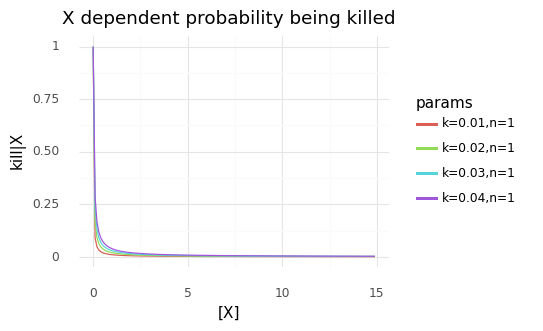

<ggplot: (8756112096001)>

In [30]:
paramsets = [
    (0.01, 1),
    (0.02, 1),
    (0.03, 1),
    (0.04, 1),
]
X = torch.arange(0.0, 15.0, 0.1)

dicts = []
for k, n in paramsets:
    name = f"k={k:.2f},n={n}"
    dicts.append({"[X]": X.tolist(), "kill|X": rev_sigm(X, k=k, n=n), "params": name})
df = pd.concat([pd.DataFrame(d) for d in dicts], ignore_index=True)

(ggplot(df)
    + geom_line(aes(x="[X]", y="kill|X", color="params"))
    + theme(figure_size=(4, 3))
    + ggtitle("X dependent probability being killed"))

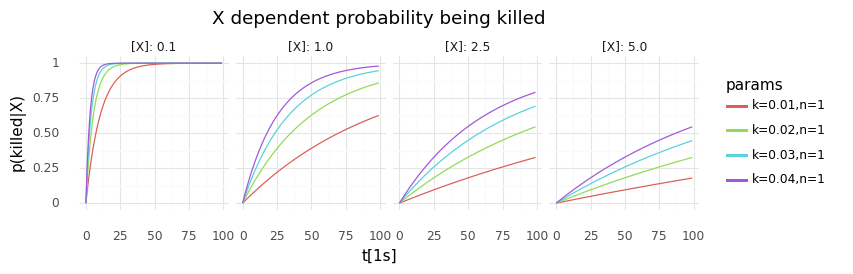

<ggplot: (8756103393917)>

In [31]:
n_steps = 100
amounts = [0.1, 1.0, 2.5, 5.0]

records = []
for k, n in paramsets:
    for amount in amounts:
        for t in range(n_steps):
            name = f"k={k:.2f},n={n}"
            p = rev_sigm(torch.tensor(amount), k=k, n=n).item()
            records.append({
                "t[1s]": t,
                "[X]": amount,
                "p(killed|X)": (1 - (1 - p) ** t),
                "params": name,
            })
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="t[1s]", y="p(killed|X)", color="params"))
    + facet_grid("~ [X]", labeller="label_both", scales="free_x")
    + theme(figure_size=(8, 2))
    + ggtitle("X dependent probability being killed"))

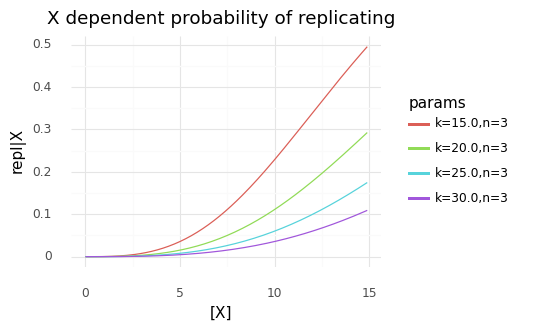

<ggplot: (8756119188721)>

In [32]:
paramsets = [
    (15.0, 3),
    (20.0, 3),
    (25.0, 3),
    (30.0, 3),
]
X = torch.arange(0.0, 15.0, 0.1)

dicts = []
for k, n in paramsets:
    name = f"k={k:.1f},n={n}"
    dicts.append({"[X]": X.tolist(), "repl|X": sigm(X, k=k, n=n), "params": name})
df = pd.concat([pd.DataFrame(d) for d in dicts], ignore_index=True)

(ggplot(df)
    + geom_line(aes(x="[X]", y="repl|X", color="params"))
    + theme(figure_size=(4, 3))
    + ggtitle("X dependent probability of replicating"))

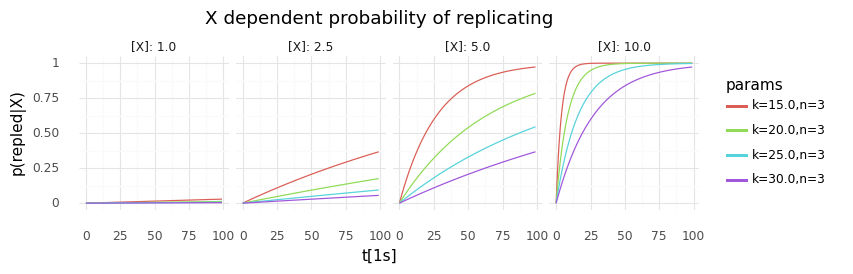

<ggplot: (8756103393419)>

In [33]:
n_steps = 100
amounts = [1.0, 2.5, 5.0, 10.0]

records = []
for k, n in paramsets:
    for amount in amounts:
        for t in range(n_steps):
            name = f"k={k:.1f},n={n}"
            p = sigm(torch.tensor(amount), k=k, n=n).item()
            records.append({
                "t[1s]": t,
                "[X]": amount,
                "p(repled|X)": (1 - (1 - p) ** t),
                "params": name,
            })
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="t[1s]", y="p(repled|X)", color="params"))
    + facet_grid("~ [X]", labeller="label_both", scales="free_x")
    + theme(figure_size=(8, 2))
    + ggtitle("X dependent probability of replicating"))